In [98]:
import os


dir = "explanations"

# list all folders in the directory
folders = [f for f in os.listdir(dir) if os.path.isdir(os.path.join(dir, f))]
folders

['graph_Synth_cycle_6_house_GCN_GraphMaskExplainer',
 'graph_Synth_house_wheel_GCN_GradExplainer',
 'graph_Synth_cycle_6_house_GCN_GradExplainer',
 'graph_AlkaneCarbonyl_GCN_SubgraphX',
 'graph_Mutagenicity_GCN_SubgraphX',
 'graph_Synth_house_wheel_GCN_GNNExplainer',
 'graph_Synth_cycle_6_house_GCN_GNNExplainer',
 'graph_FluorideCarbonyl_GCN_GNNExplainer',
 'graph_AlkaneCarbonyl_GCN_Random',
 'graph_Synth_wheel_cube_GCN_GradExplainer',
 'graph_AlkaneCarbonyl_GCN_GNNExplainer',
 'graph_Mutagenicity_GCN_PGMExplainer',
 'graph_Synth_bull_4_cycle_GCN_Random',
 'graph_AlkaneCarbonyl_GCN_GraphMaskExplainer',
 'graph_Synth_bull_4_cycle_GCN_GradExplainer',
 'graph_FluorideCarbonyl_GCN_PGMExplainer',
 'graph_AlkaneCarbonyl_GCN_PGMExplainer',
 'graph_Mutagenicity_GCN_GNNExplainer',
 'graph_Synth_wheel_cube_GCN_GraphMaskExplainer',
 'graph_Synth_wheel_cube_GCN_Random',
 'graph_Benzene_GCN_SubgraphX',
 'graph_Synth_house_wheel_GCN_Random',
 'graph_FluorideCarbonyl_GCN_SubgraphX',
 'graph_Synth_hou

In [99]:
import json

import numpy as np
import pandas as pd

dfs = {}
best_hps = {}
for fl in folders:
    file_path = os.path.join(dir, fl, "complexes_metrics.json")
    graph_path = os.path.join(dir, fl, "graph_metrics.json")

    try:
        print(f"Loading data from {file_path}")
        with open(file_path, "r") as f:
            data = json.load(f)
    
        with open(graph_path, "r") as f:
            graph_data = json.load(f)

        from pprint import pprint
        best_per_seed = []

        # get best per seed for each combo of hyperparameters prop_method, alpha_c, alpha_e
        hp_combos = set()
        prop_methods = set()
        per_hp_metrics = {}
        for seed in data.keys():
            metrics = data[seed]

            # metrics is a list of dicts
            for metric in metrics:
                prop_method = metric["prop_method"]
                alpha_c = metric["alpha_c"]
                alpha_e = metric["alpha_e"]
                
                prop_methods.add(prop_method)

                hp_combos.add((prop_method, alpha_c, alpha_e))
                
                if (prop_method, alpha_c, alpha_e) not in per_hp_metrics:
                    per_hp_metrics[(prop_method, alpha_c, alpha_e)] = []
                
                per_hp_metrics[(prop_method, alpha_c, alpha_e)].append(metric["jaccard"])

        # get the avg
        avg_per_hp = {}
        for hp in per_hp_metrics.keys():
            scores = per_hp_metrics[hp]
            # get the average and standard deviation
            avg_per_hp[hp] = {
                "Average": sum(scores) / len(scores),
                "Std Deviation": np.std(scores),
            }
        
        # get best  performing metrics for each prop_method based on jaccard avg
        best_per_prop_method = {}
        best_hp_per_prop_method = {}
        for prop_method in prop_methods:
            best_per_prop_method[prop_method] = {
                "Average": 0,
                "Std Deviation": 0,
            }
            for hp in avg_per_hp.keys():
                if hp[0] == prop_method:
                    if avg_per_hp[hp]["Average"] > best_per_prop_method[prop_method]["Average"]:
                        best_per_prop_method[prop_method] = avg_per_hp[hp]
                        best_hp_per_prop_method[prop_method] = hp

        best_hps[fl] = best_hp_per_prop_method

        data = best_per_prop_method

        prop_methods.add("Baseline")
        data["Baseline"] = {
            "Average": graph_data["average"]["jaccard"],
            "Std Deviation": graph_data["std_dev"]["jaccard"],
        }
        # Convert data to a suitable format for Seaborn
        df_data = []
        for prop_method, metrics in data.items():
            for metric_name, values in metrics.items():
                if metric_name in ["accuracy", "precision", "recall"]:
                    continue
                df_data.append(
                    {
                        "Propagation Method": prop_method,
                        "Metric": metric_name,
                        "Average Score": values,
                    }
                )

        df = pd.DataFrame(df_data)
        dfs[fl] = df
        # save the data 
        df.to_csv(f"metrics/{fl}_metrics.csv", index=False)
    
    except Exception as e:
        print(e)
        print(f"Could not load data from {file_path}")
        continue


Loading data from explanations/graph_Synth_cycle_6_house_GCN_GraphMaskExplainer/complexes_metrics.json
Loading data from explanations/graph_Synth_house_wheel_GCN_GradExplainer/complexes_metrics.json
Loading data from explanations/graph_Synth_cycle_6_house_GCN_GradExplainer/complexes_metrics.json
Loading data from explanations/graph_AlkaneCarbonyl_GCN_SubgraphX/complexes_metrics.json
Loading data from explanations/graph_Mutagenicity_GCN_SubgraphX/complexes_metrics.json
Loading data from explanations/graph_Synth_house_wheel_GCN_GNNExplainer/complexes_metrics.json
Loading data from explanations/graph_Synth_cycle_6_house_GCN_GNNExplainer/complexes_metrics.json
Loading data from explanations/graph_FluorideCarbonyl_GCN_GNNExplainer/complexes_metrics.json
Loading data from explanations/graph_AlkaneCarbonyl_GCN_Random/complexes_metrics.json
Loading data from explanations/graph_Synth_wheel_cube_GCN_GradExplainer/complexes_metrics.json
Loading data from explanations/graph_AlkaneCarbonyl_GCN_GNNE

In [105]:

pprint(best_hps)
# save as json
with open("best_hps.json", "w") as f:
    json.dump(best_hps, f, indent=4)

{'graph_AlkaneCarbonyl_GCN_GNNExplainer': {'direct_prop': ('direct_prop',
                                                           1.5,
                                                           1.0),
                                           'entropy_based_propagation': ('entropy_based_propagation',
                                                                         0,
                                                                         1.5),
                                           'hierarchical_prop': ('hierarchical_prop',
                                                                 0.5,
                                                                 1.0),
                                           'nonlinear_activation_propagation': ('nonlinear_activation_propagation',
                                                                                1.5,
                                                                                1.5)},
 'graph_AlkaneCarbonyl_GC

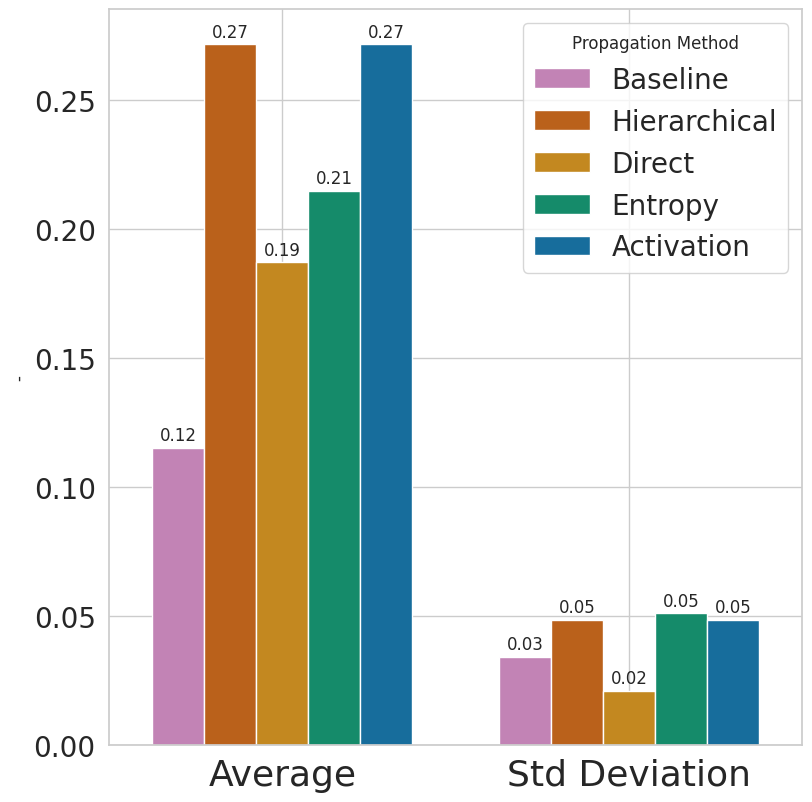

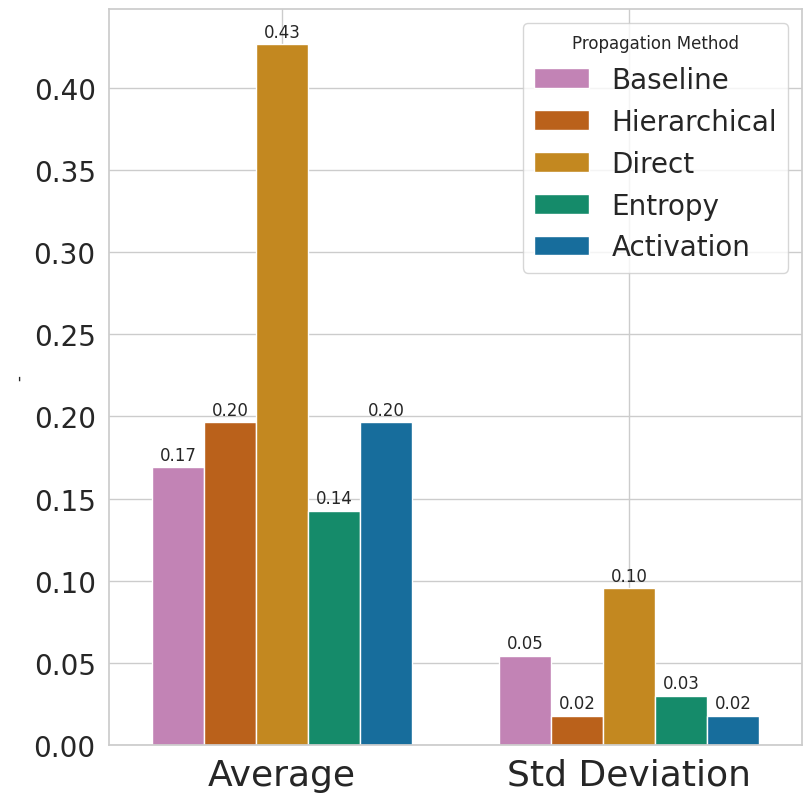

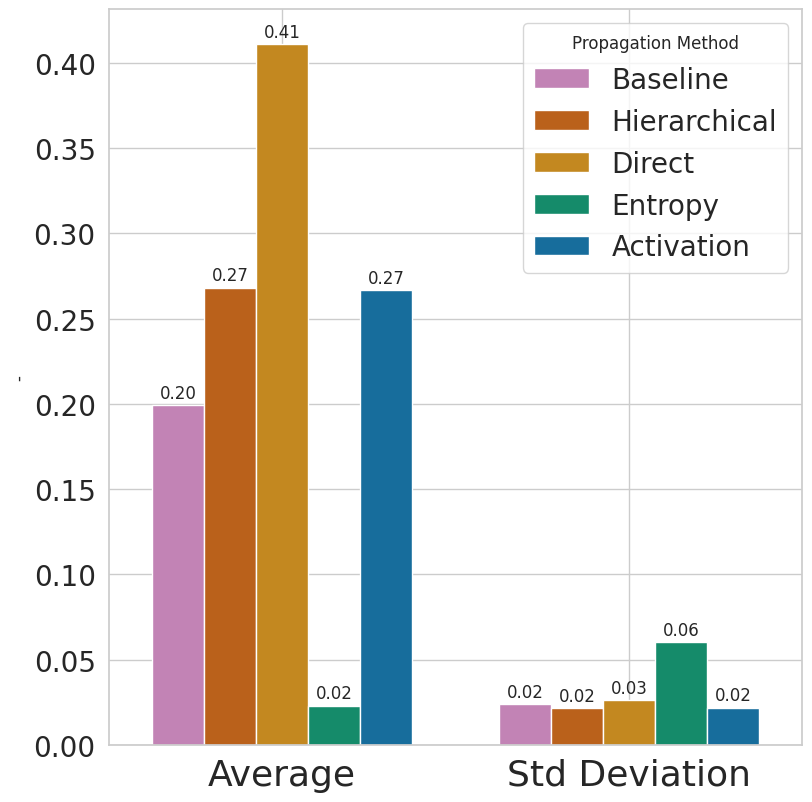

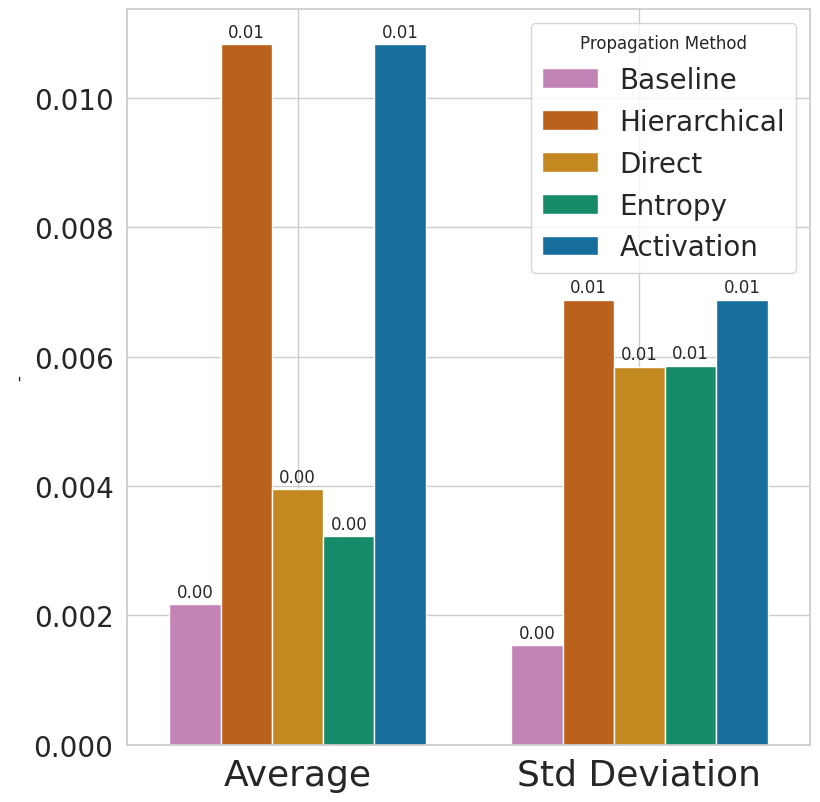

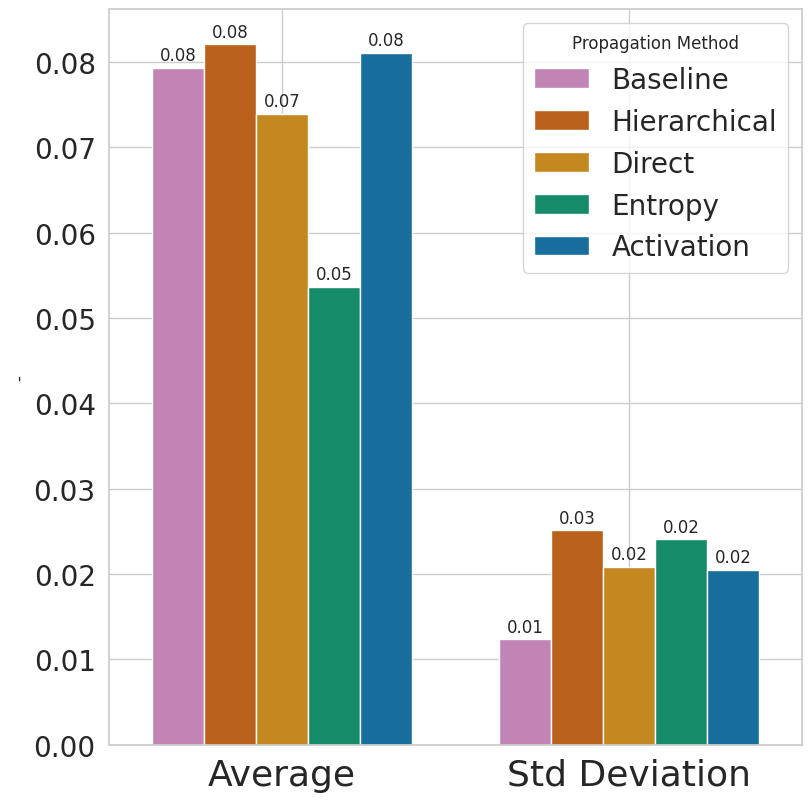

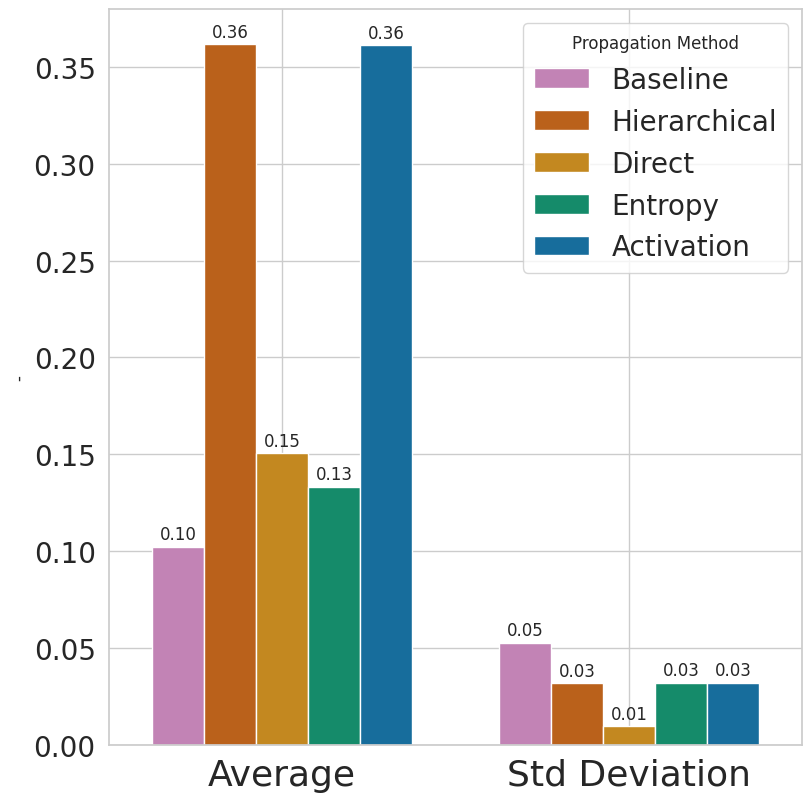

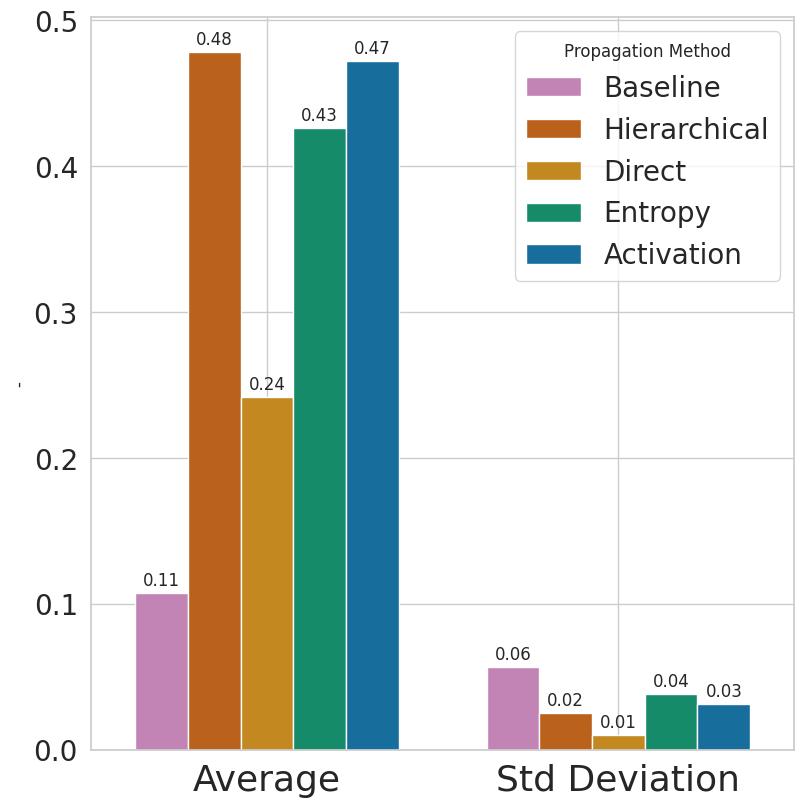

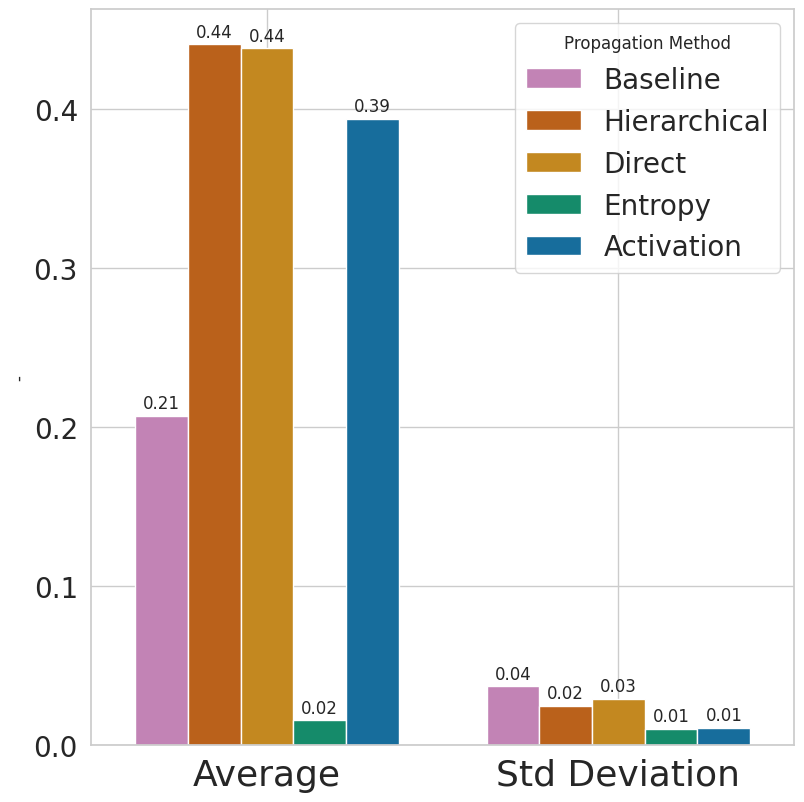

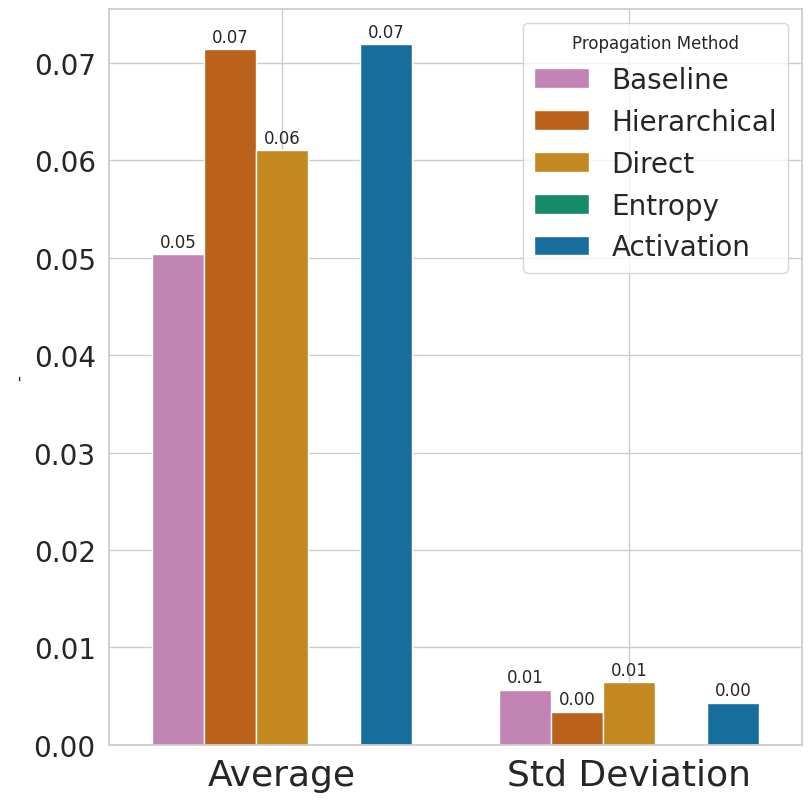

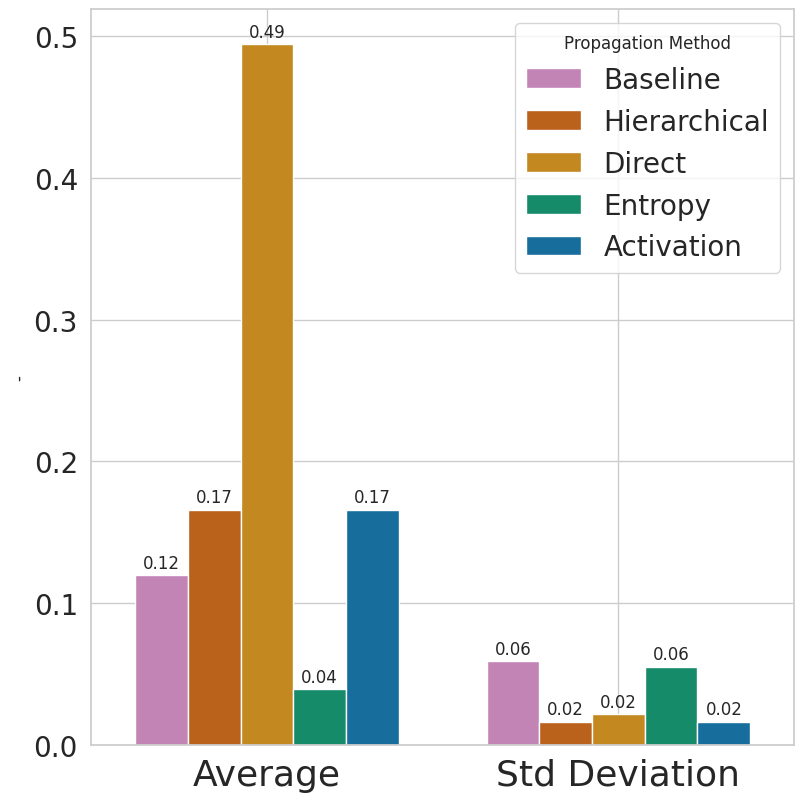

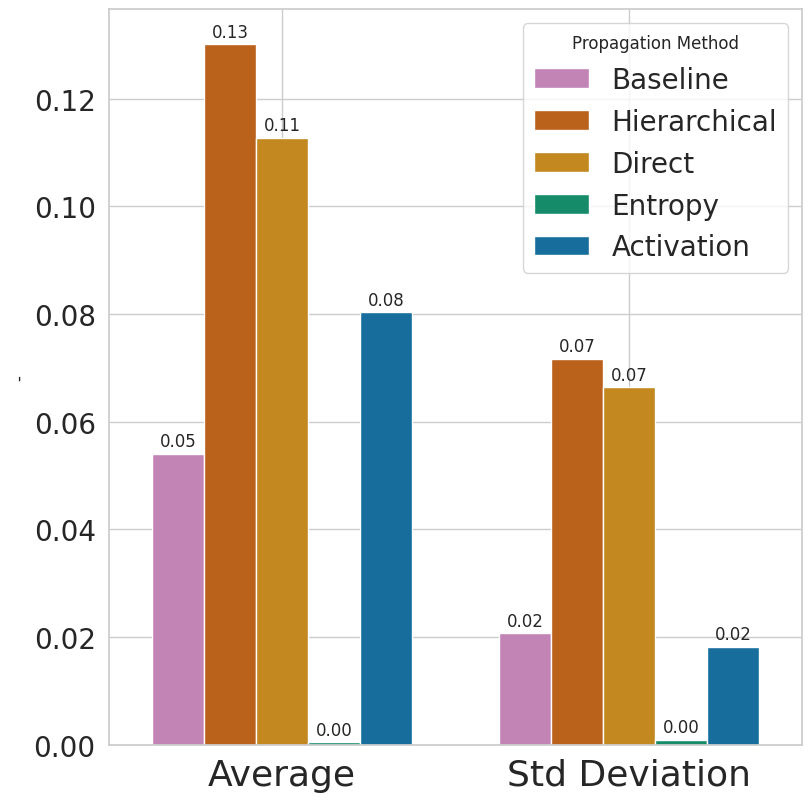

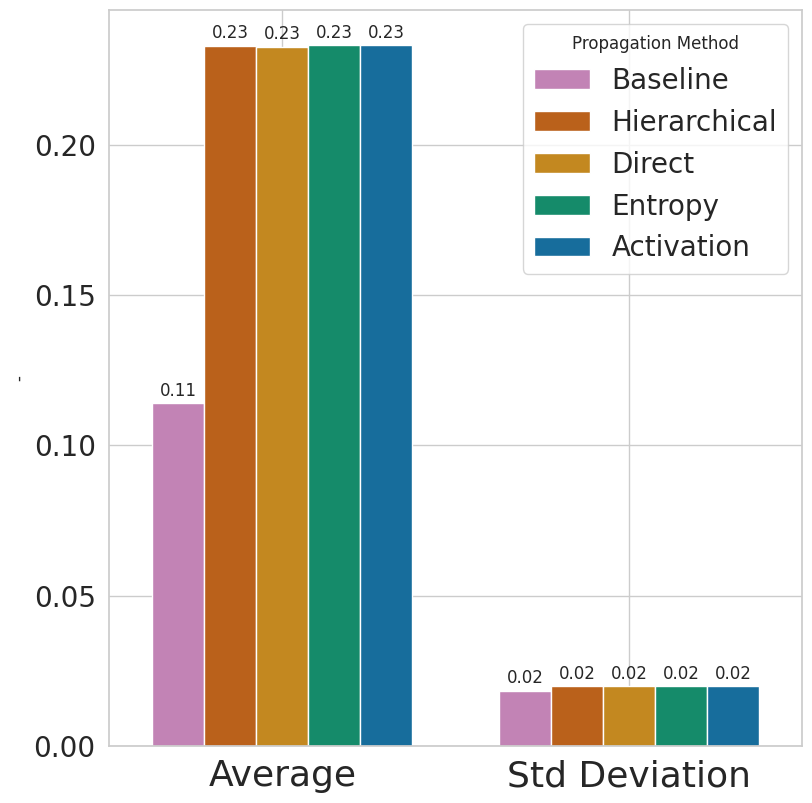

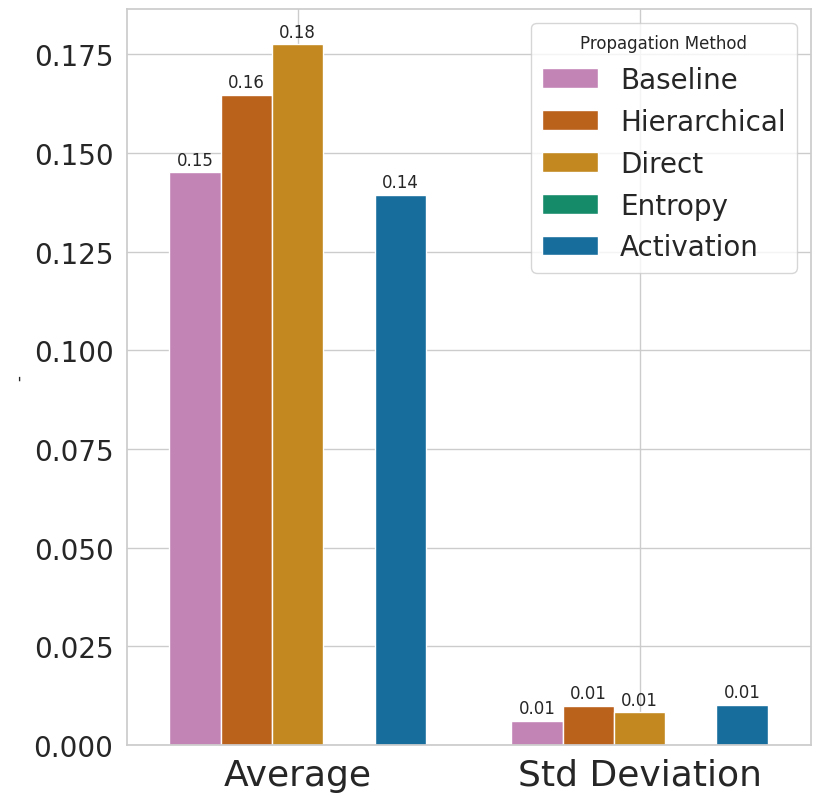

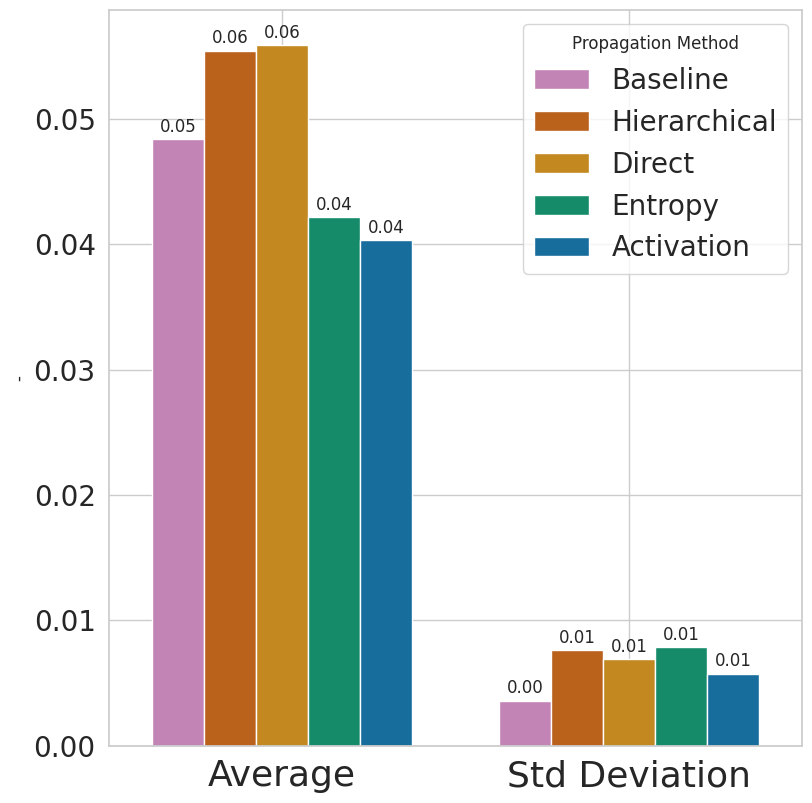

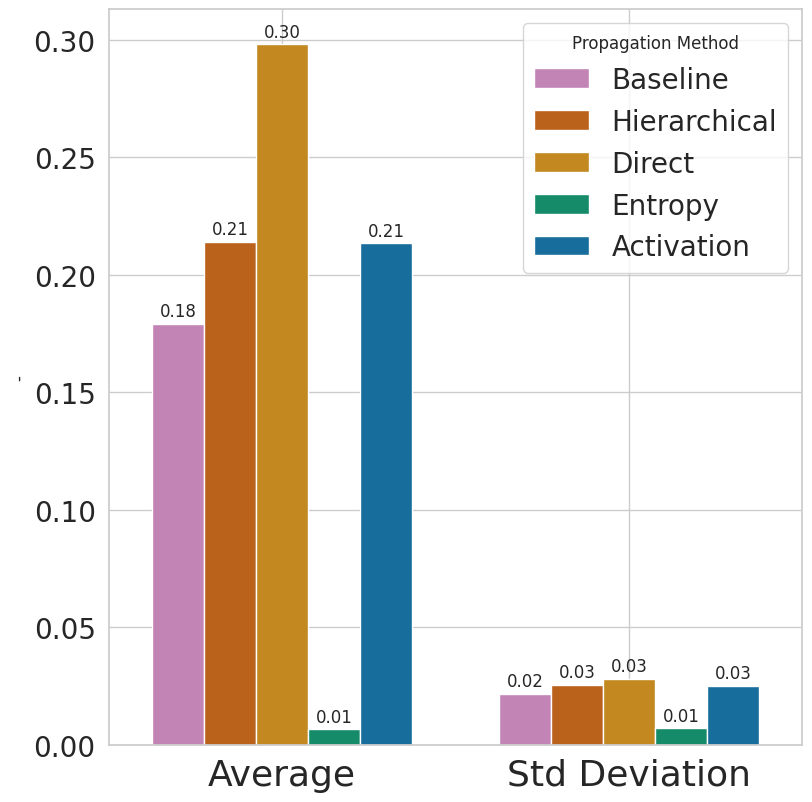

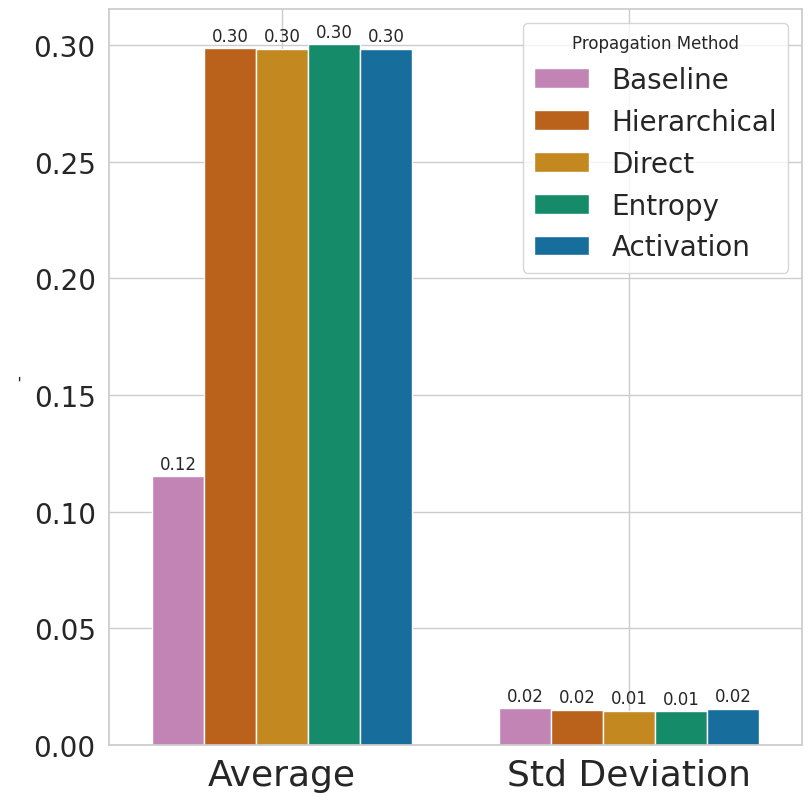

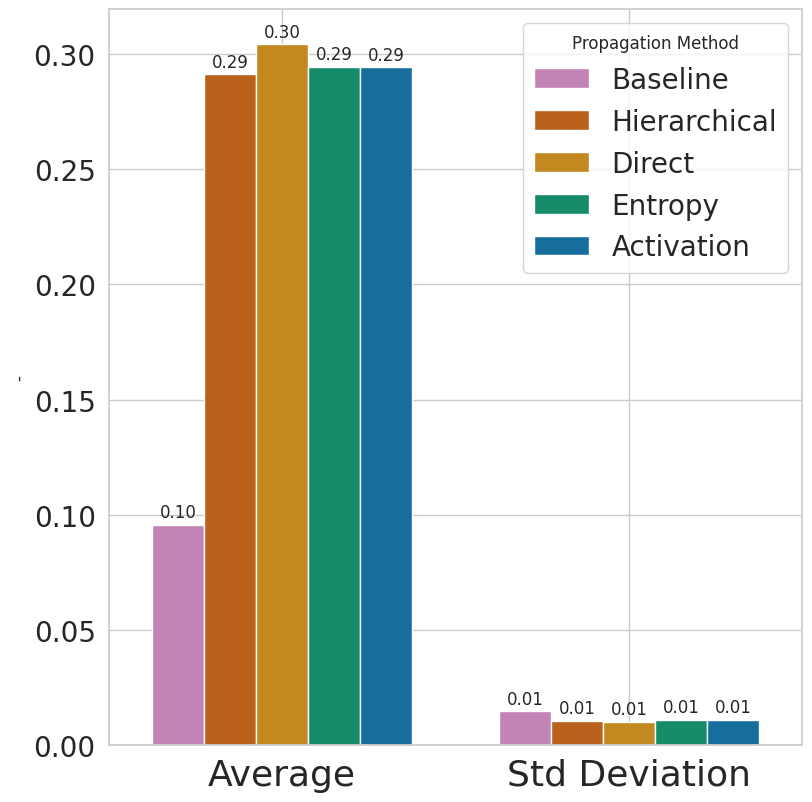

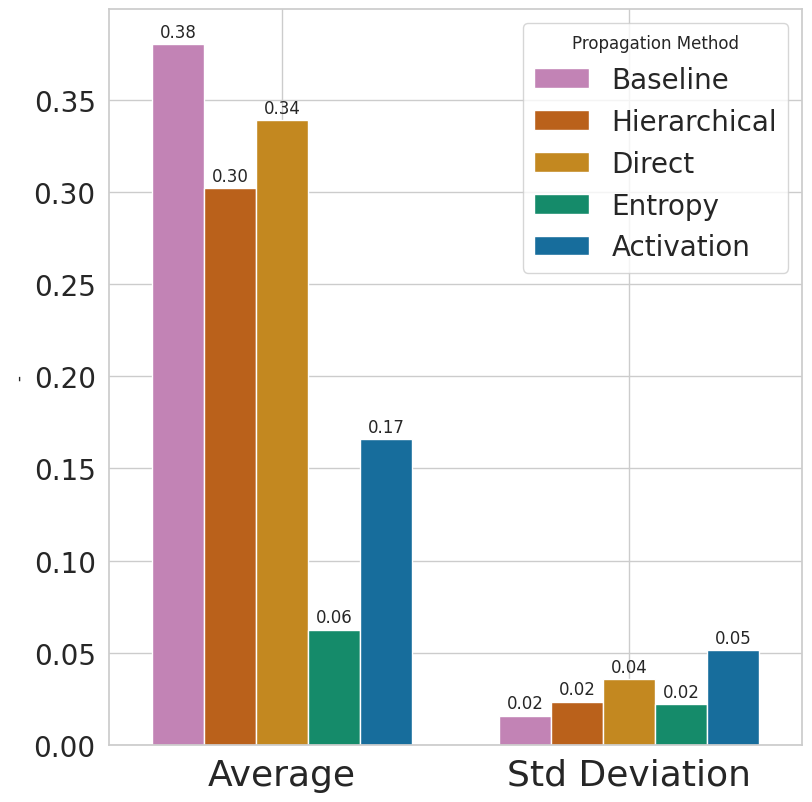

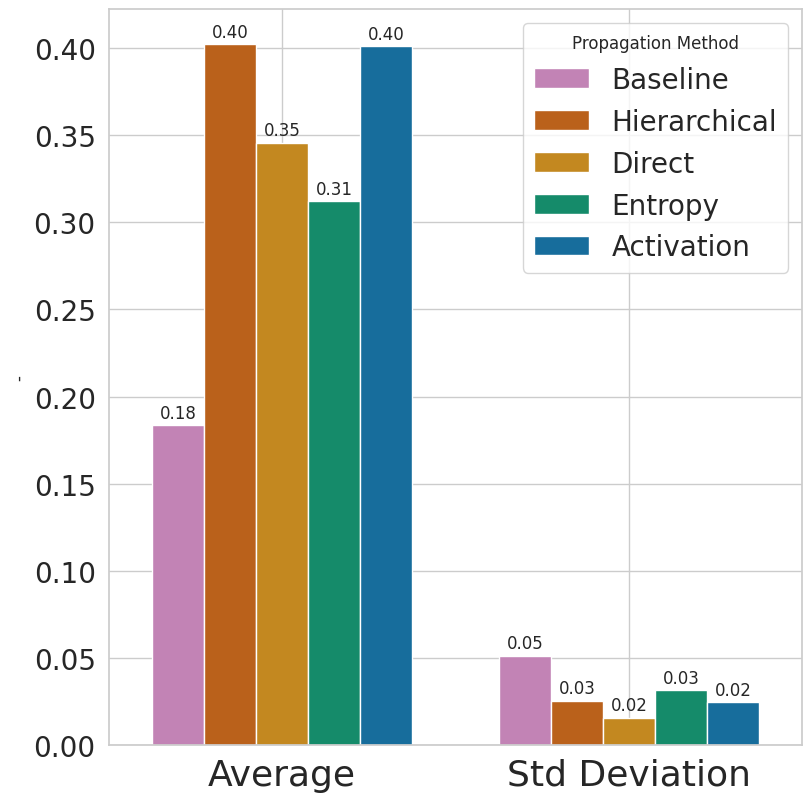

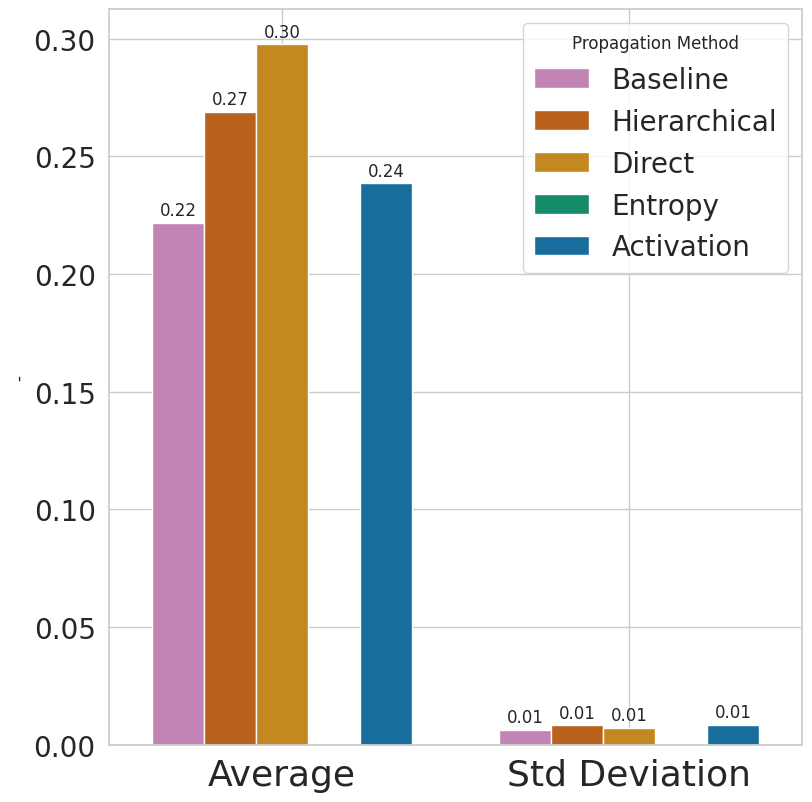

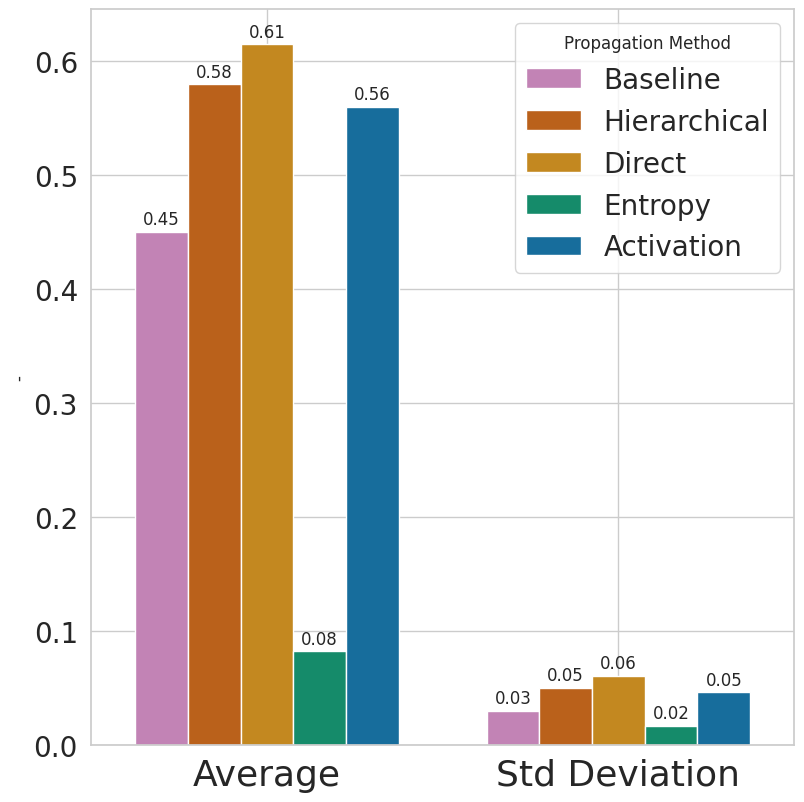

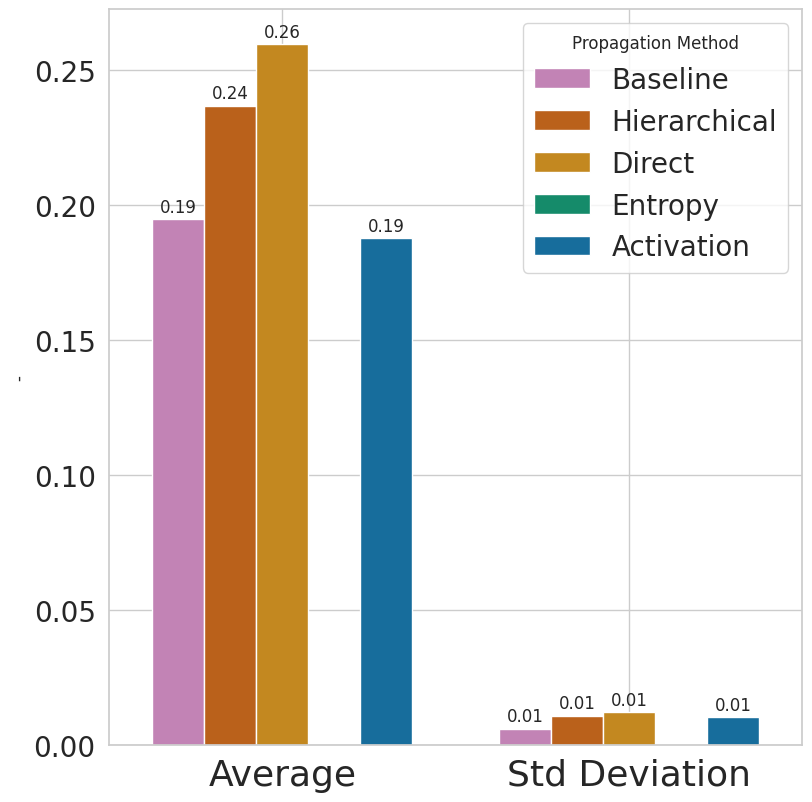

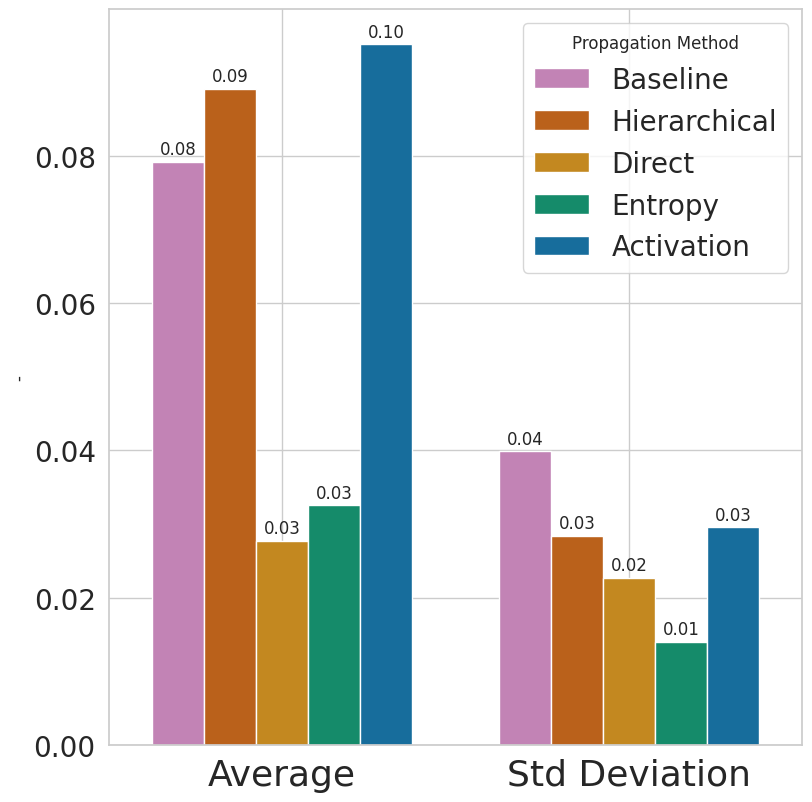

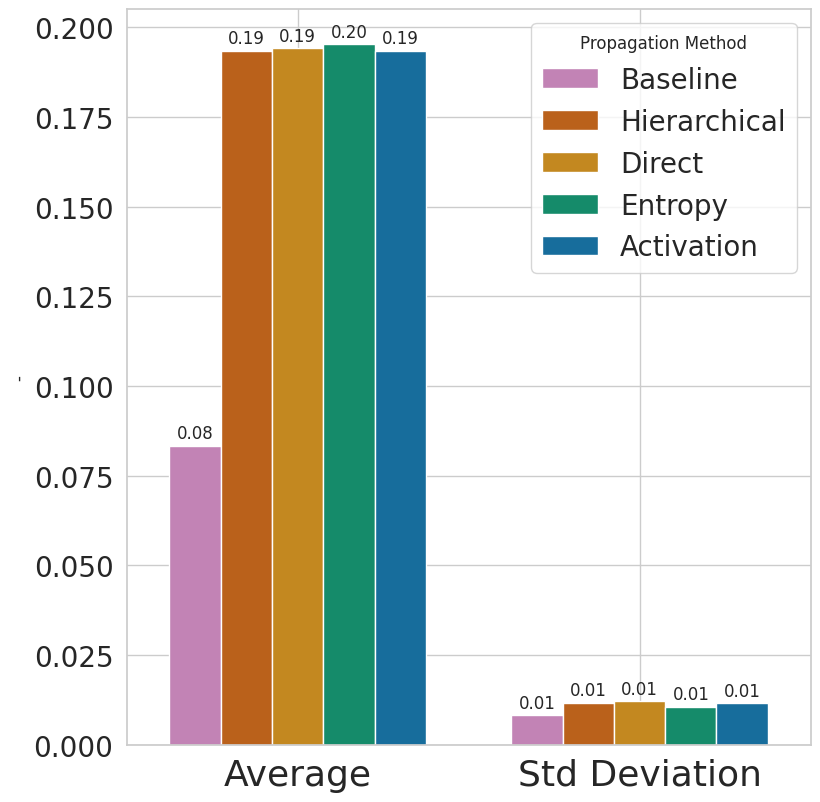

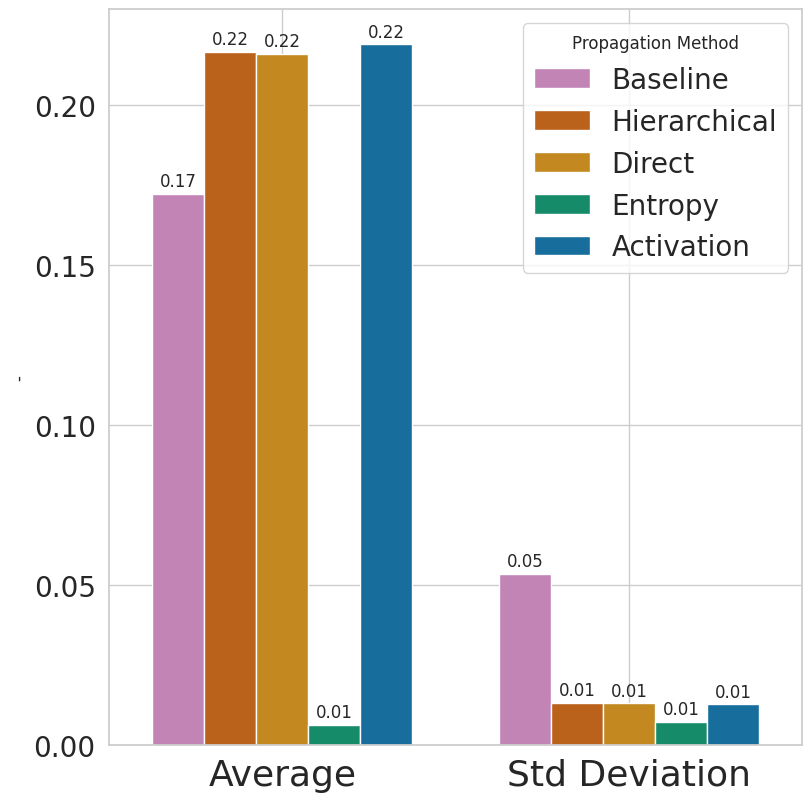

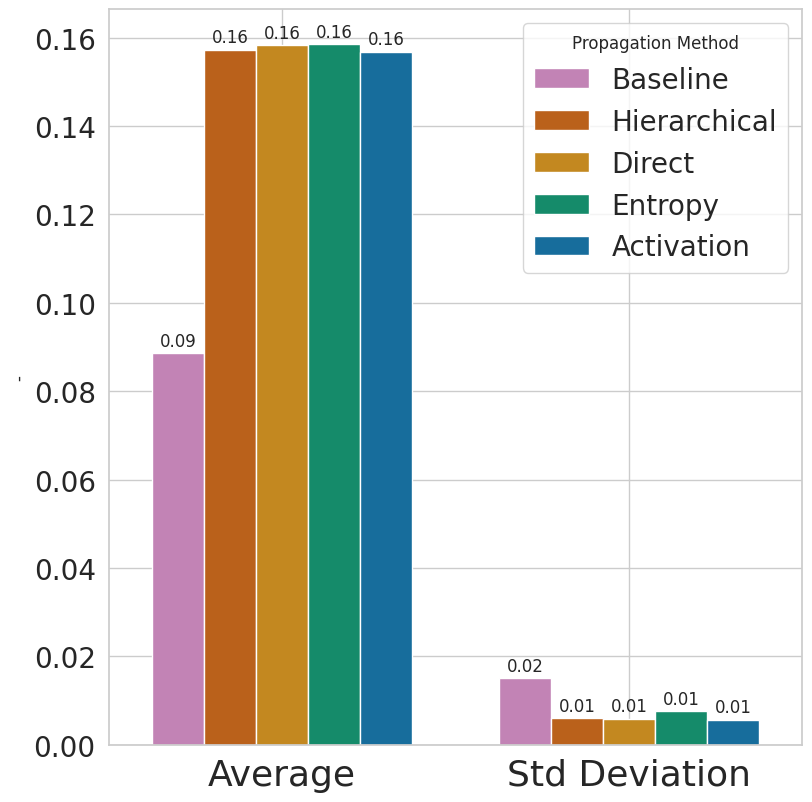

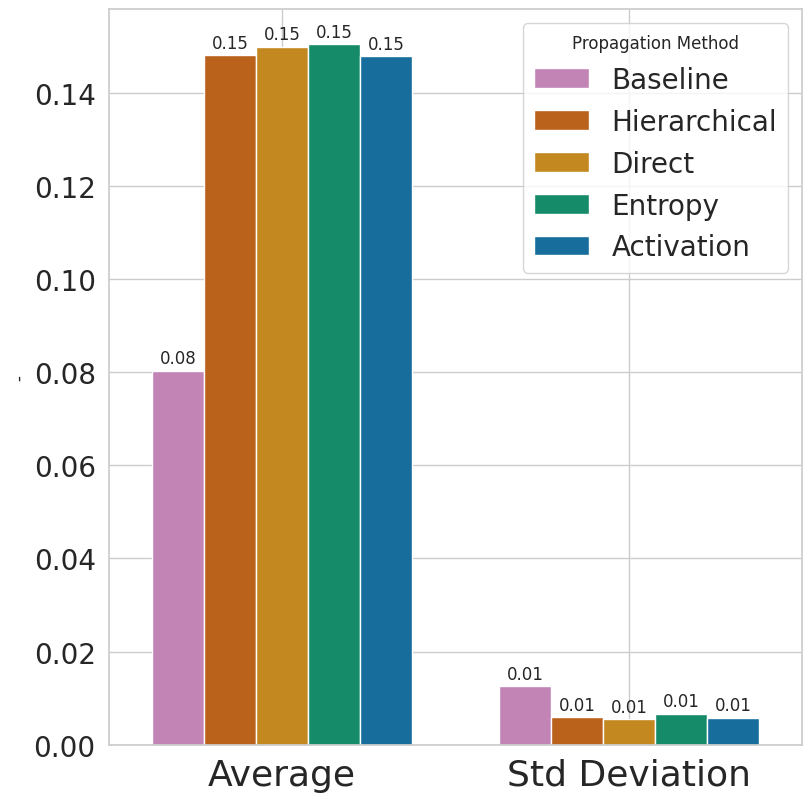

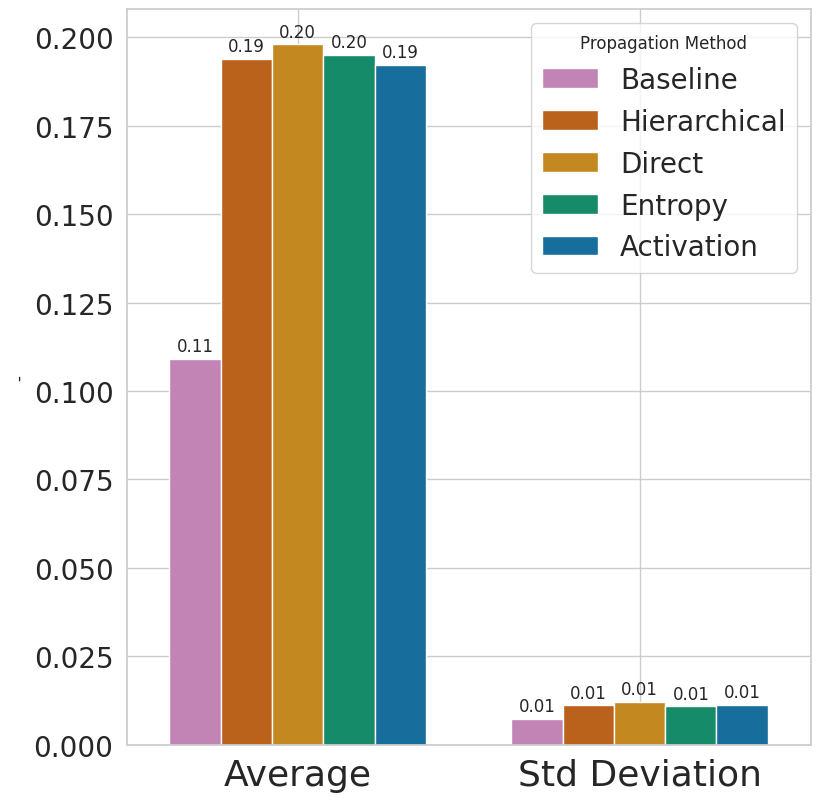

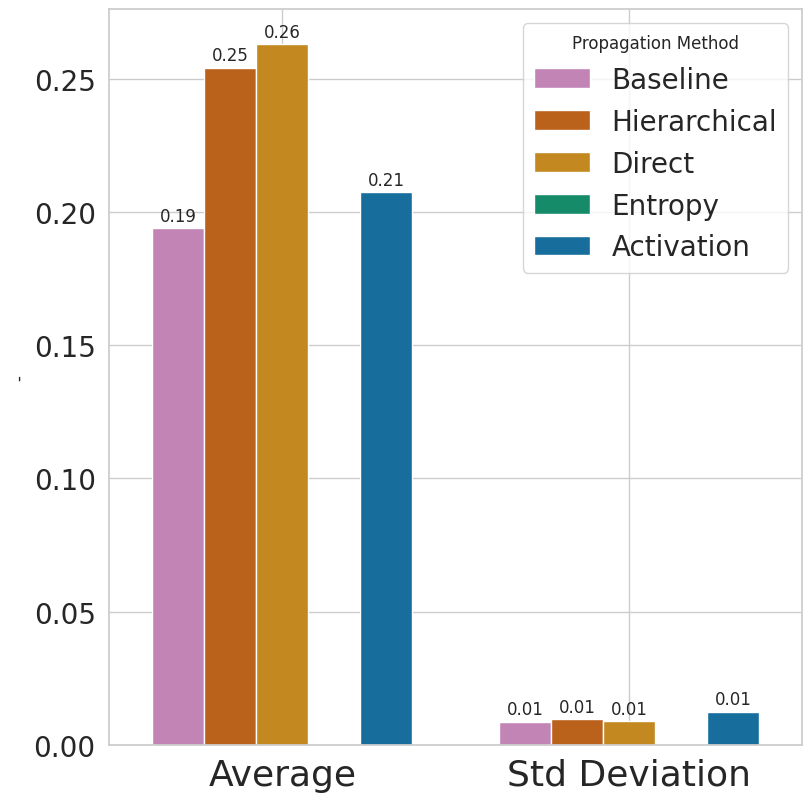

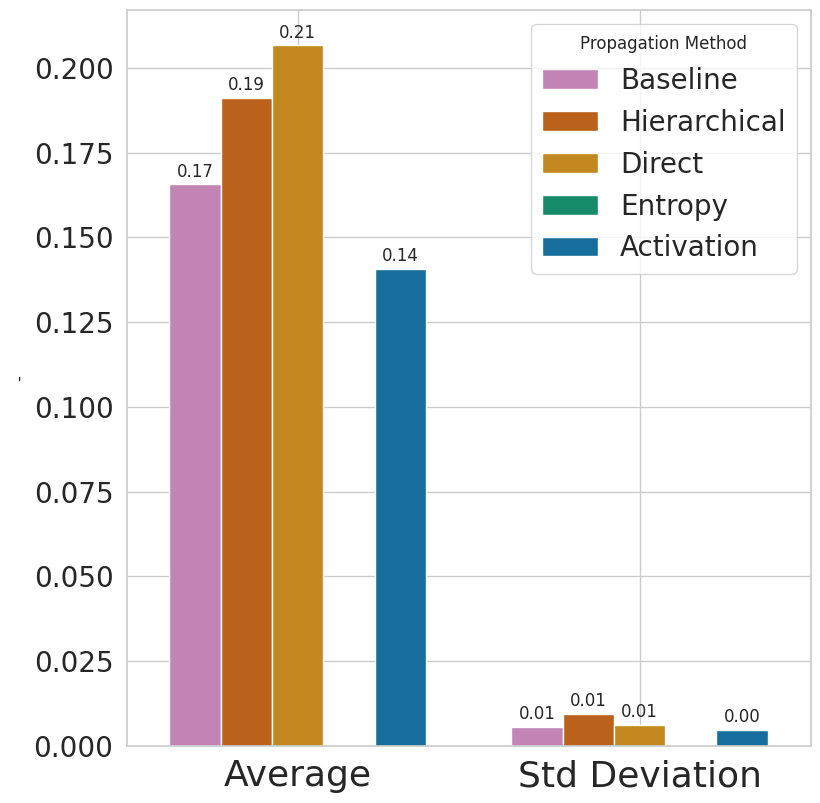

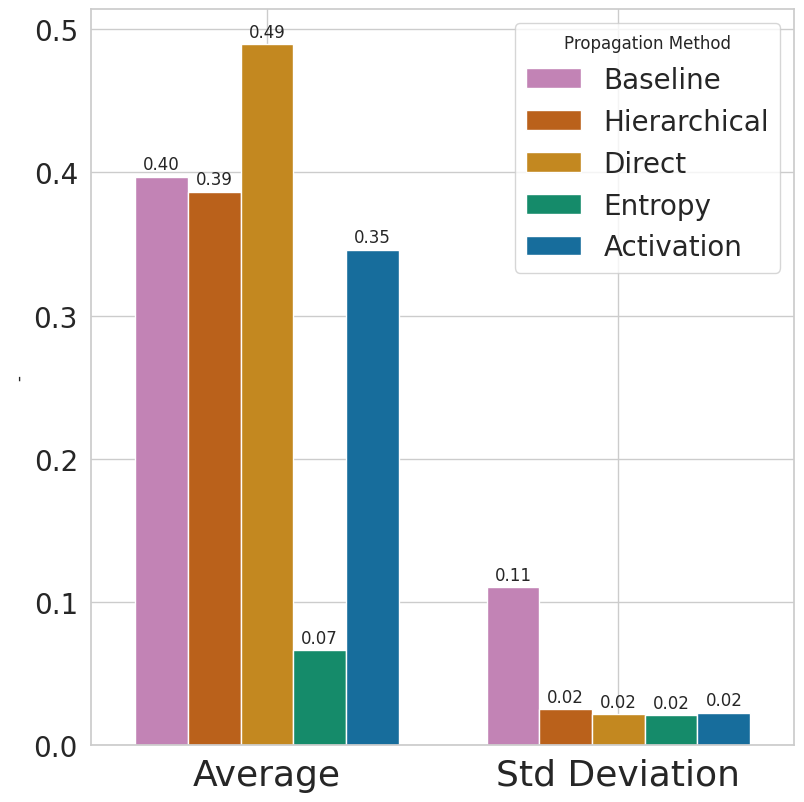

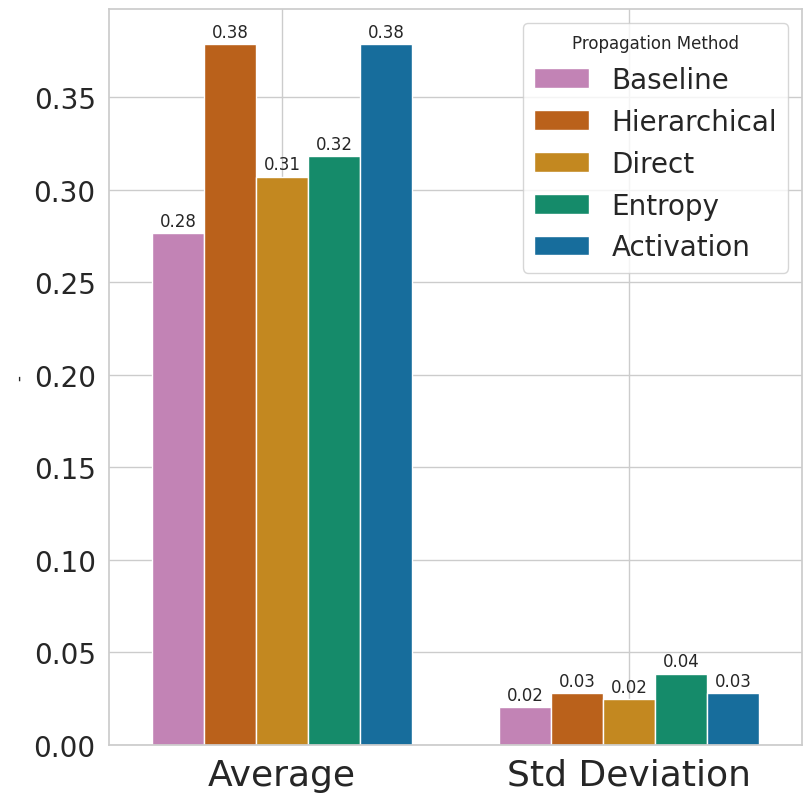

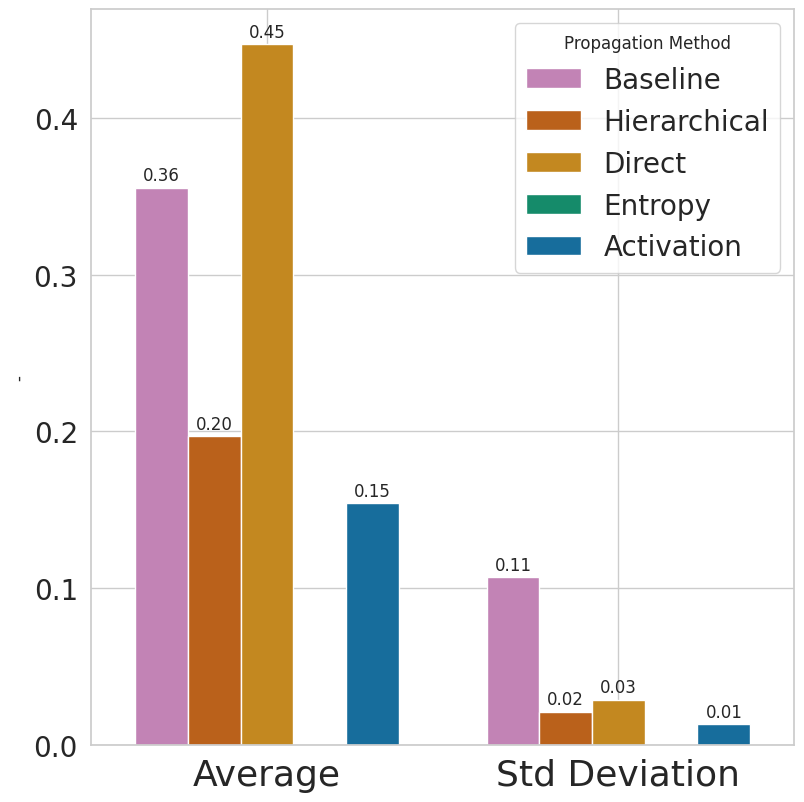

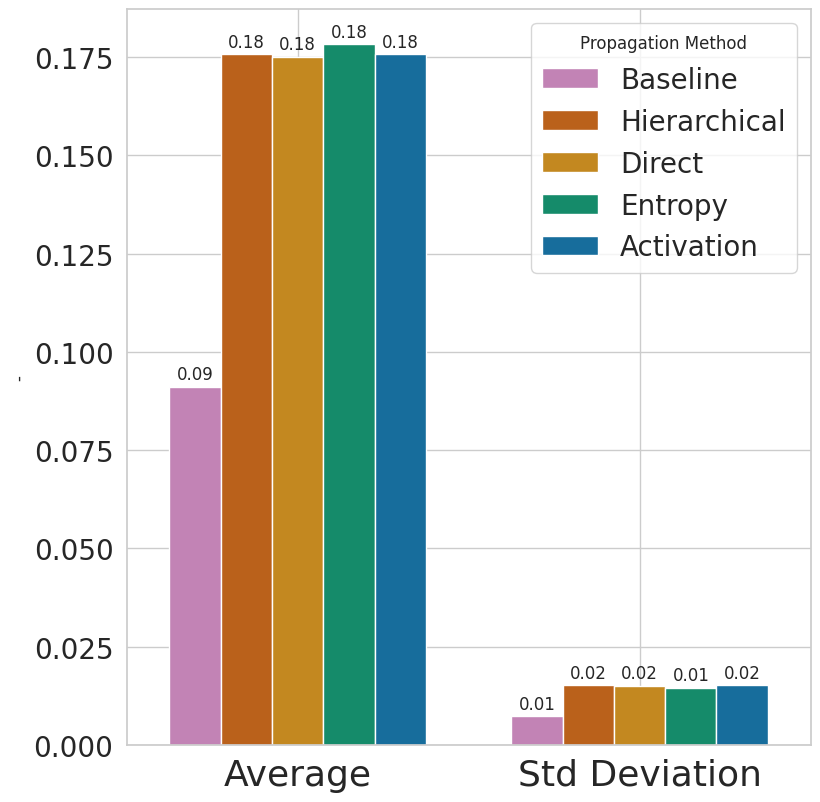

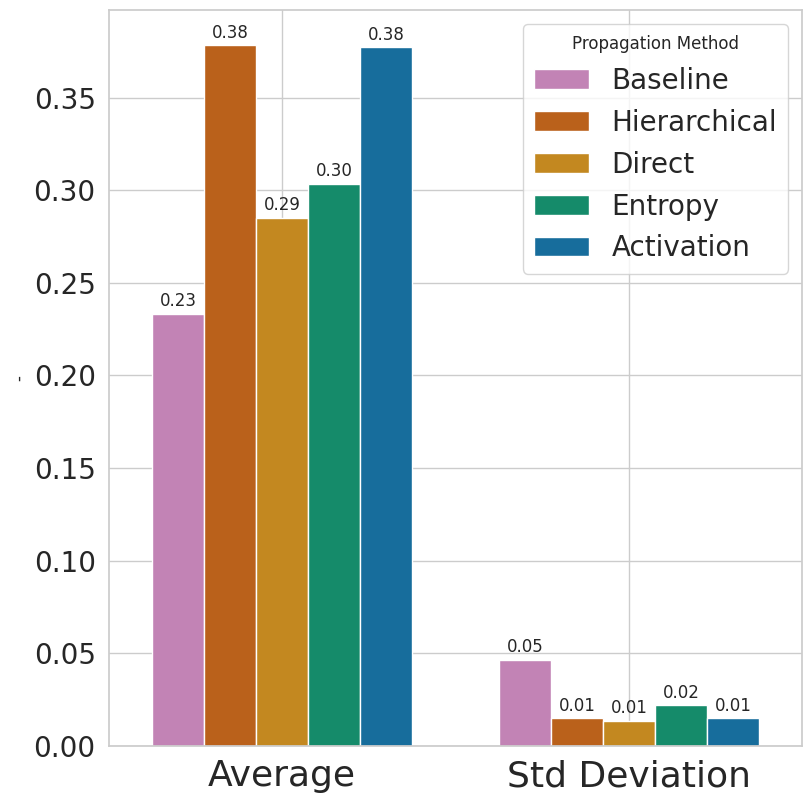

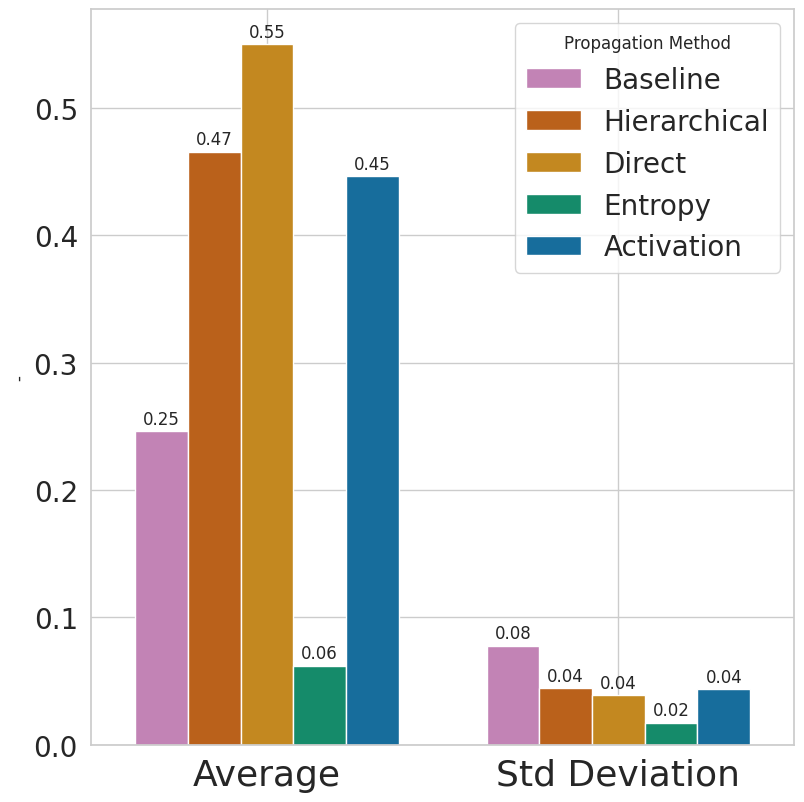

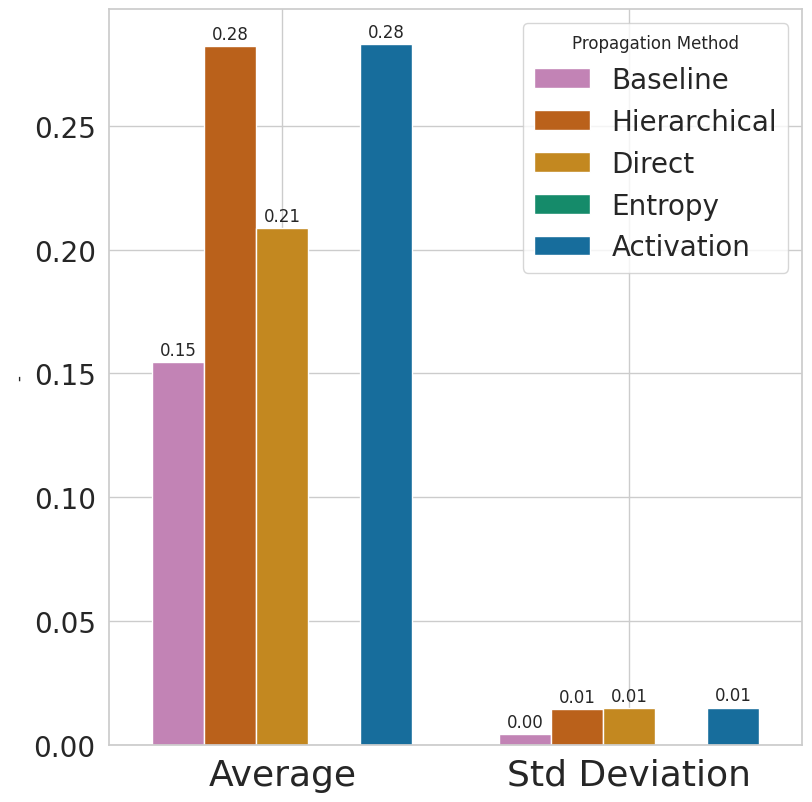

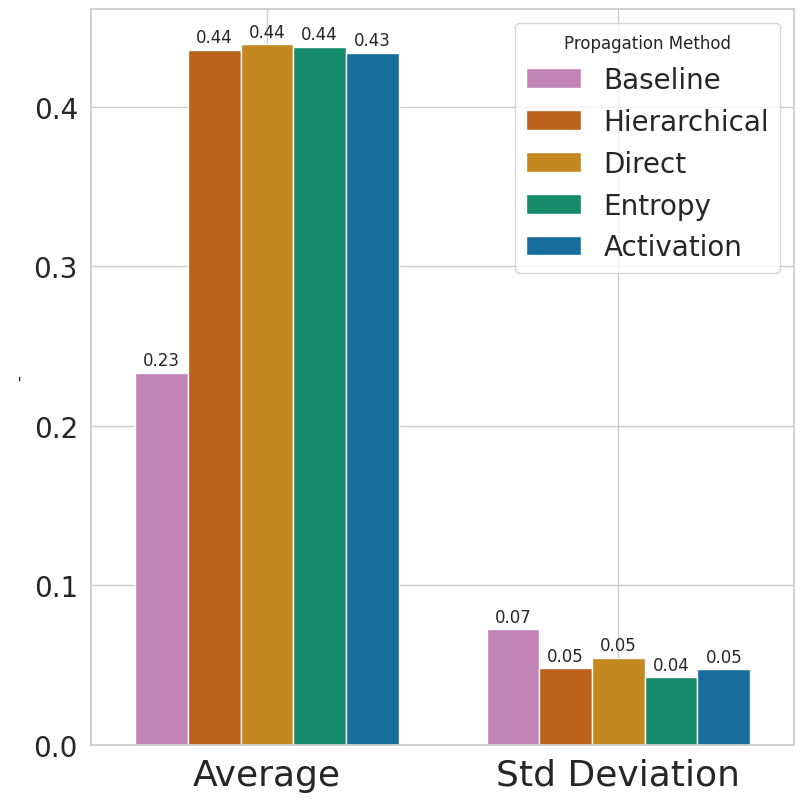

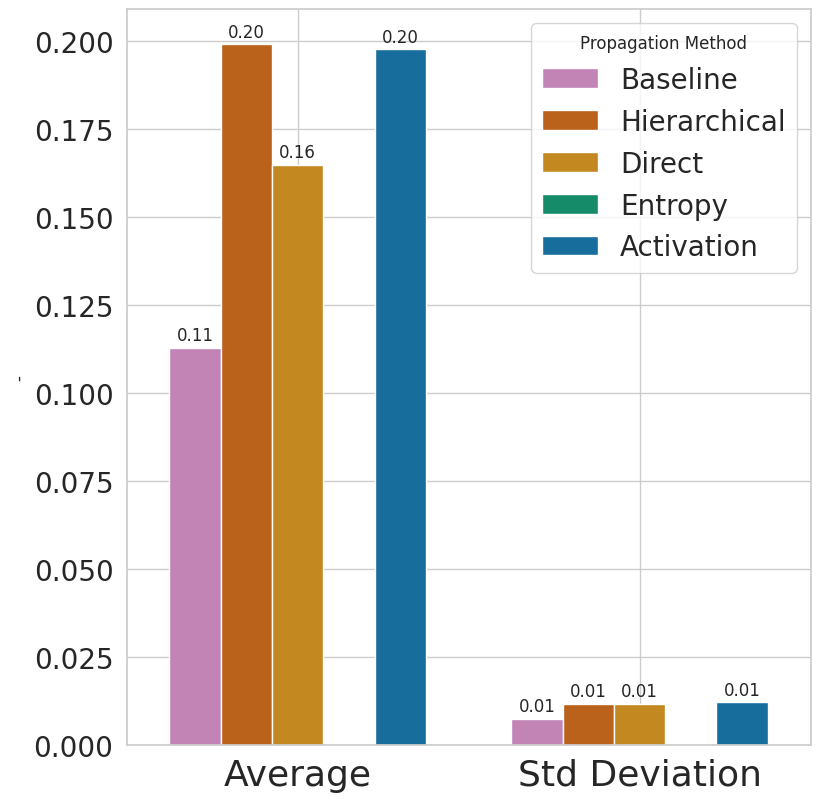

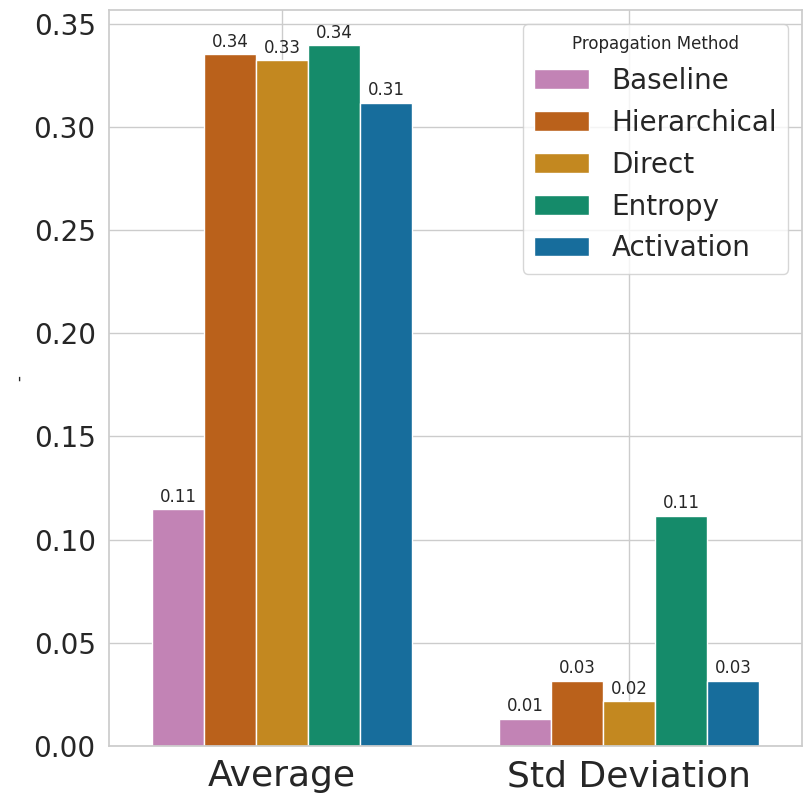

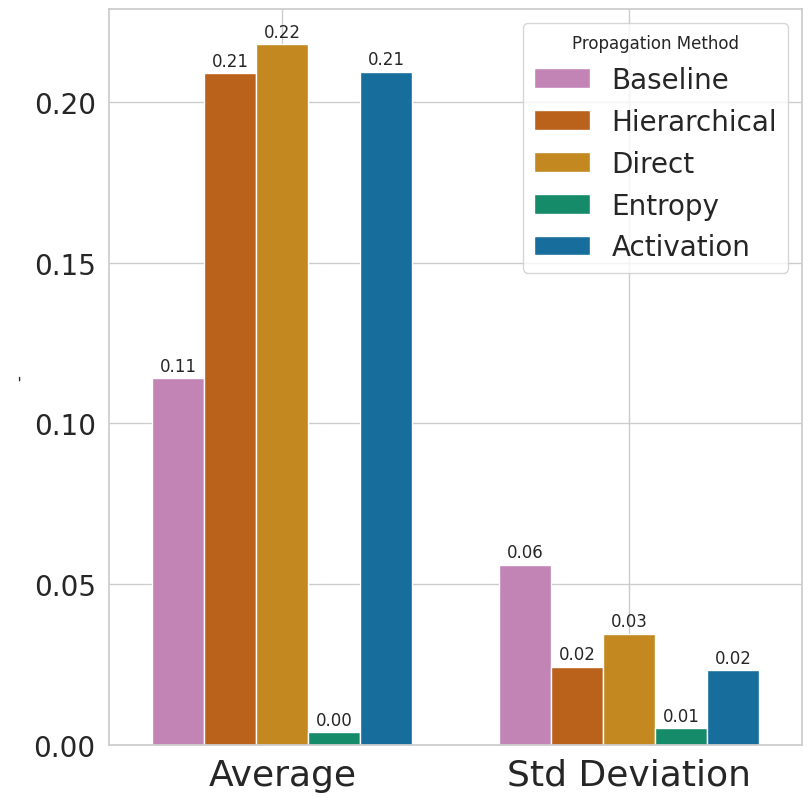

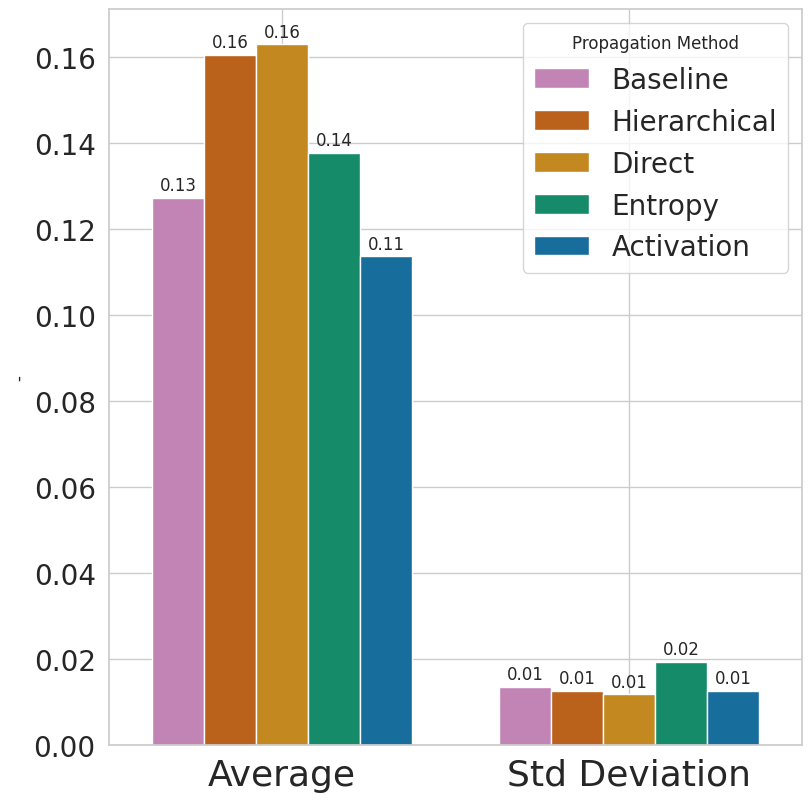

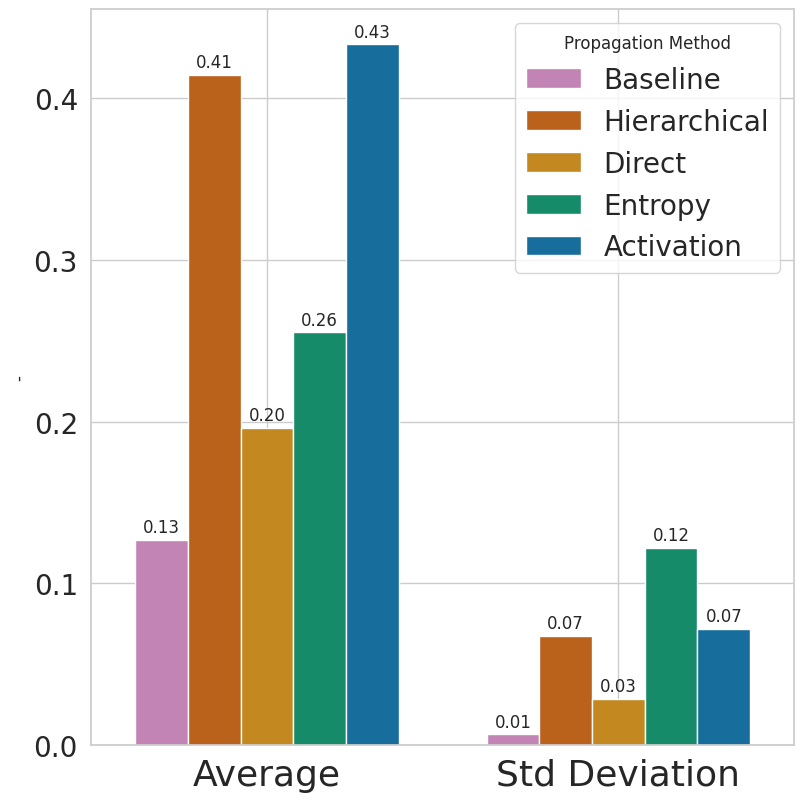

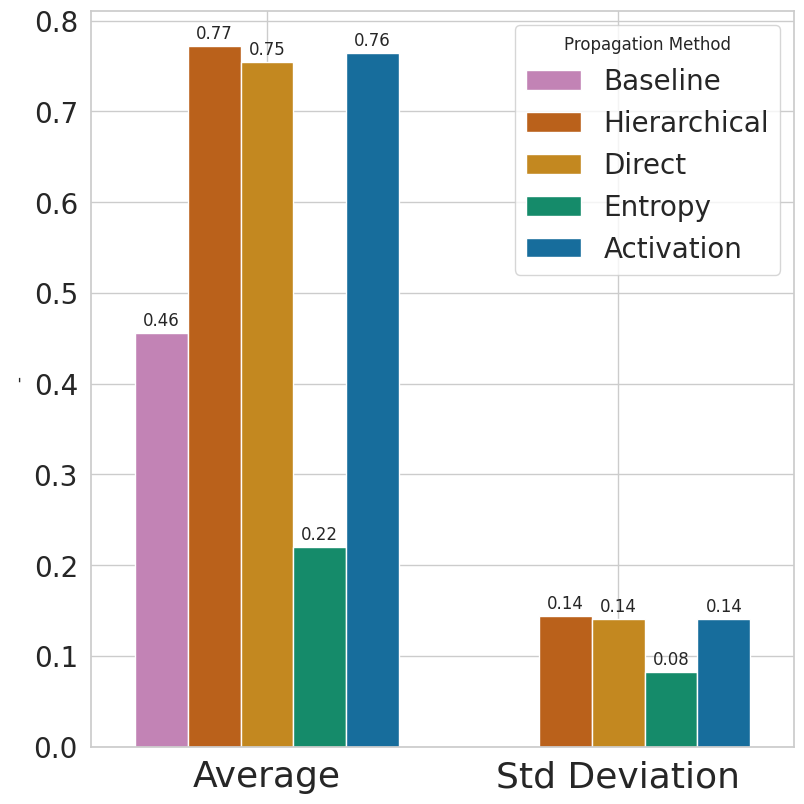

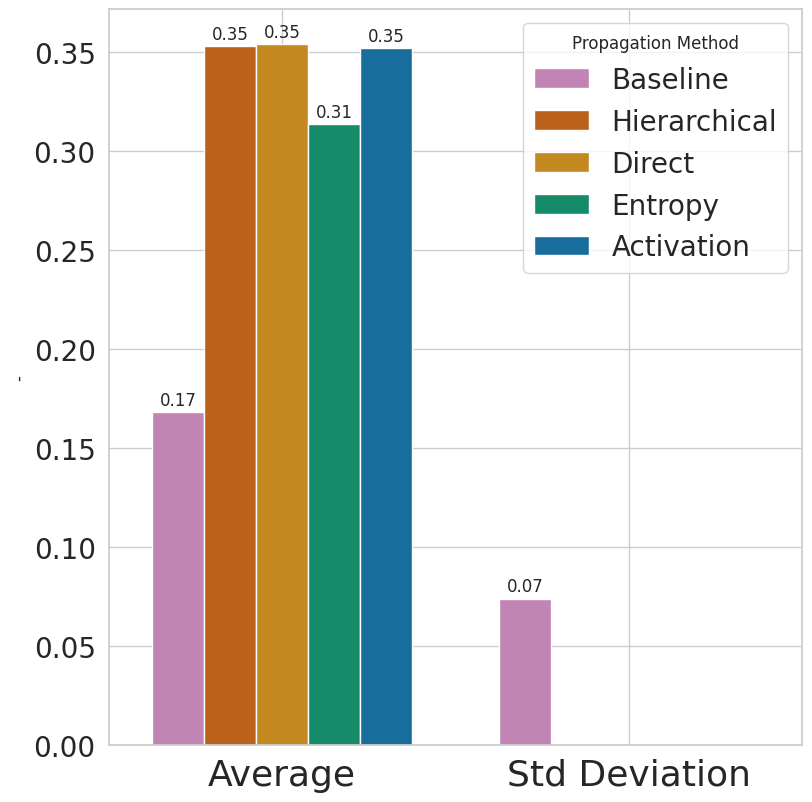

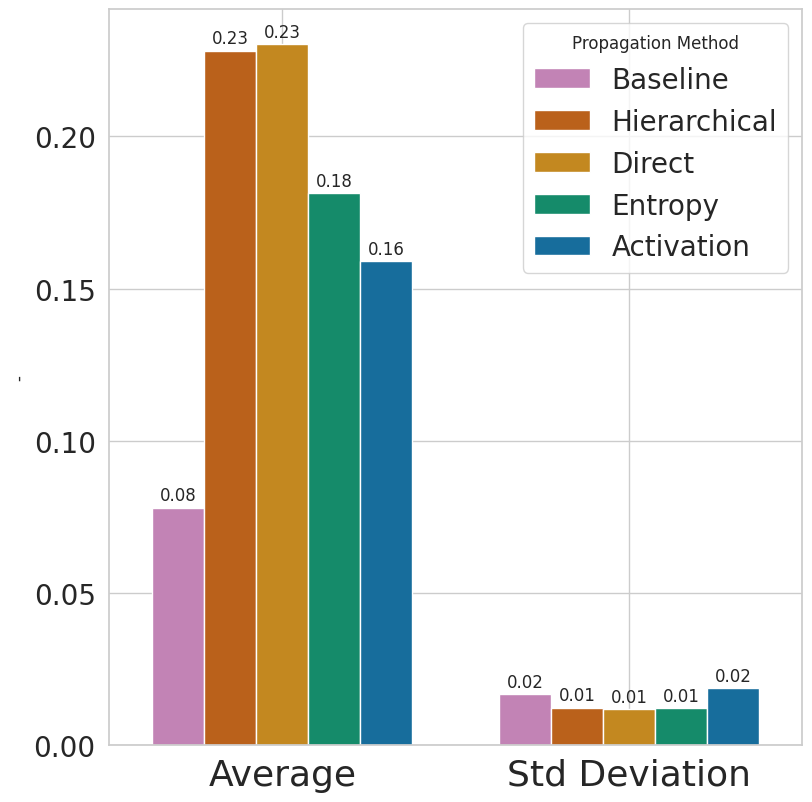

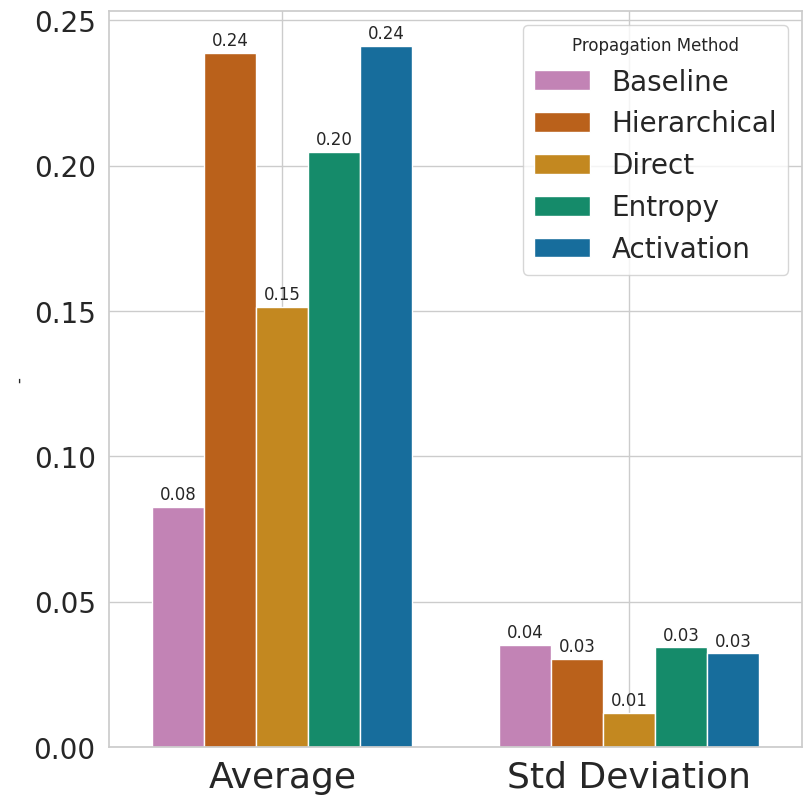

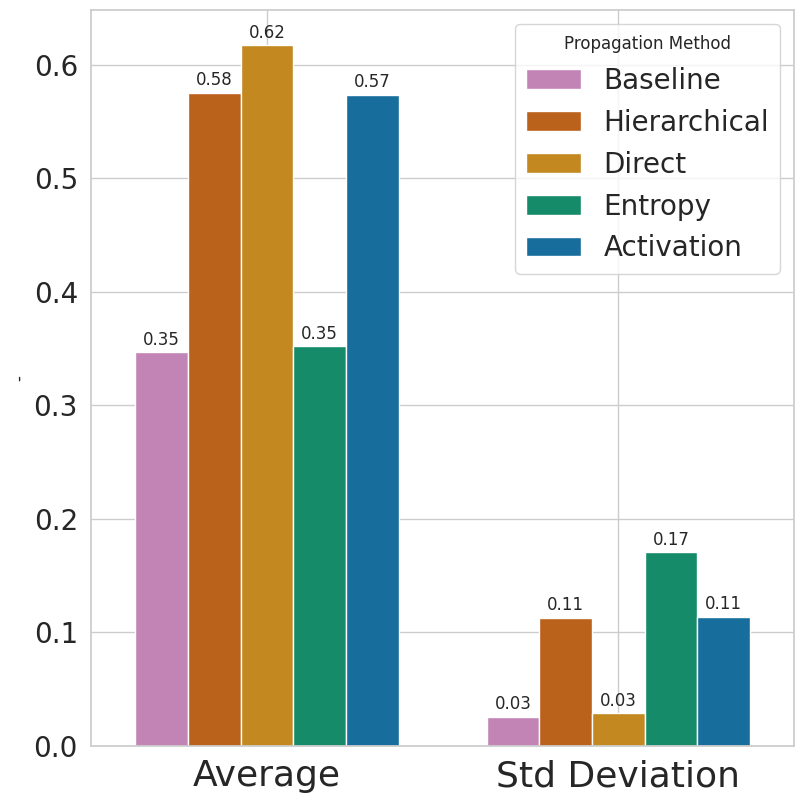

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

# create a color palette
palette = sns.color_palette("colorblind", 5)

# make a dictionary to map prop methods to names

labels = {
    "Baseline": "Baseline",
    'hierarchical_prop': "Hierarchical",
    'direct_prop': "Direct",
    'entropy_based_propagation': "Entropy",
    'nonlinear_activation_propagation': "Activation",
}

colors = {}
for i, prop_method in enumerate(prop_methods):
    colors[labels[prop_method]] = palette[i]
    

for fl, df in dfs.items():
    sns.set(style="whitegrid")  # Set the Seaborn style

    # replace Propagation Method with the actual names
    df["Propagation Method"] = df["Propagation Method"].apply(lambda x: labels[x])
    
    # make sure prop methods are ordered correctly alphabetically
    df["Propagation Method"] = pd.Categorical(df["Propagation Method"], categories=labels.values(), ordered=True)
    
    # fill the "graph" bars with a different style

    plt.figure(figsize=(8, 8))  # Set the figure size
    barplot = sns.barplot(
        x="Metric",
        y="Average Score",
        hue="Propagation Method",
        data=df,
        palette=colors,
        capsize=0.1,
        width=0.75,
    )


    plt.xlabel("")
    plt.ylabel("-")
    plt.legend(title="Propagation Method", fontsize=20)
    plt.grid(True)
    plt.tight_layout()  # Adjust the layout
    
    # make ticks and labels bigger
    plt.xticks(fontsize=26)
    plt.yticks(fontsize=20)

    # add the actual values on top of the bars
    for p in barplot.patches:
        if p.get_height() <= 0:
            continue
        barplot.annotate(
            format(p.get_height(), ".2f"),
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="center",
            xytext=(0, 9),
            textcoords="offset points",
        )
        
    # save svg
    plt.savefig(f"plots/{fl}_metrics.svg", format="svg")

    plt.show()